# Recurrent Neural Networks

RNNs are a family of neural networks for processing sequential data. 

We have seen how convolutional neural networks are specialized in processing a grid of values $X$. In the same way, RNNs are specialized in processing a sequence of values $x^{(1)}, x^{(2)}, \dots, x^{(\tau)}$. 

To go from MLP to RNN, we again need to take advantage of parameter sharing so that we can process sequences of arbitrary length (just like we did with CNNs for images of arbitrary size). In other words, if we used an MLP, the input layer has a fixed dimensionality, which we do not want. Some sequences may be shorter or longer than other sequences. 

Of course, we could use a 1-D convolution operation on a sequence of data, for which parameter sharing is still applied and this approach is scalable to arbitrary sequence lengths. This is actually the basis for [time-delay networks](https://en.wikipedia.org/wiki/Time_delay_neural_network). However, this type of parameter sharing is not the same as that of RNNs. Using a 1-D convolution means that the output is a product of the input and a small neighbourhood around the input at each time point of the sequence. RNNs instead compute the output based on every single input that came before a specific time step. 

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

## Sequential models

Before delving into RNNs, let's specify what we mean by sequence modeling. A very naive approach is to look at the last $\tau$ instances to predict the next instance in the sequence. 

This type of sequence model is called a **Markov chain model**, and mathematically, it is defined as:

$P(y^{(t+1)} \;|\; y^{(t)}, y^{(t-1)}, \dots, y^{(t-\tau-1)}, y^{(t-\tau)})$

In other words, it models the probability of an output $y$ at time step $t+1$ based on all previous $y$ outputs from time step $t$ to $t-\tau$.

For example, if $\tau = 3$, we get

$P(y^{(t+1)} \;|\; y^{(t)}, y^{(t-1)}, y^{(t-2)}, y^{(t-3)})$

- The conditioning set $\{y^{(t)}, y^{(t-1)}, y^{(t-2)}, y^{(t-3)}\}$ of this probability can be seen as the **input** to our model. 
- The value we are calculating the probability over, i.e., $y^{(t+1)}$ can be seen as the **output** of our model.
- The probability function itself can be seen as the **model** we are attempting to approximate. 

Since our inputs and output always have a fixed length, we can use a linear regression model to predict the relationship between inputs and output.  

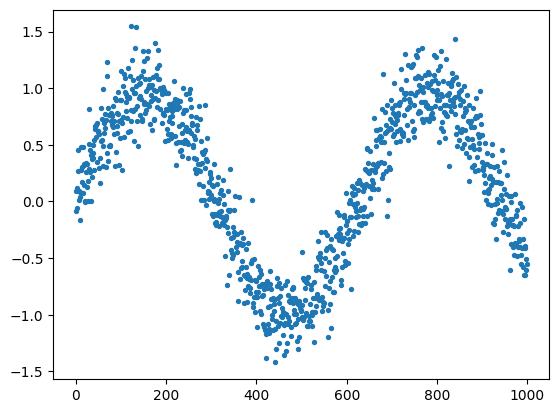

In [2]:
# let's generate a sine wave sequence with a bit of noise
N = 1000
x = torch.arange(0, N, 1)
y = torch.sin(0.01 * x) + torch.normal(0, 1, size=(N,)) * 0.2

plt.scatter(x, y, s=8)

Here, we implement our own linear regression model using PyTorch

In [3]:
from torch.utils.data import DataLoader
from torch.optim import SGD

class LinearRegression(nn.Module):
    def __init__(self, alpha=0.1, batch_size=32, epochs=10, learning_rate=0.01) -> None:
        super().__init__()
        self.alpha = alpha                      # regularization parameter
        self.batch_size = batch_size            # number of batches to process at one time
        self.epochs = epochs                    # number of epochs to train the model
        self.learning_rate = learning_rate      # optimization step size
        self.net = nn.LazyLinear(1)             # simple linear layer
        self.net.weight.data.normal_(0, 0.01)   # initialize weights to be gaussian N(0, 0.01)
        self.net.bias.data.fill_(0)             # initialize bias to be zero
        self.criterion = nn.MSELoss()           # loss criterion is MSE
        self.losses = None
    
    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y):
        return self.criterion(y_hat, y)
    
    def fit(self, X: torch.Tensor, y: torch.Tensor):
        self.losses = []
        
        # weight_decay parameter ensures regularization, meaning the magnitude of the weight is contrained to be small
        optim = SGD(self.net.parameters(), self.learning_rate, weight_decay=self.alpha)

        # create simple training set
        training_set = torch.cat([X, y.reshape(-1, 1)], dim=1)
        train_dataloader = DataLoader(training_set, self.batch_size, shuffle=True)

        for _ in range(self.epochs):
            
            batch_loss = []
            for batch in train_dataloader:
                # last column is the output
                train_X = batch[:, :-1]
                train_y = batch[:, -1].reshape(-1, 1)

                y_hat = self.net(train_X)

                loss = self.loss(y_hat, train_y)
                batch_loss.append(loss.item())

                # optimization step
                loss.backward()
                optim.step()
                optim.zero_grad()
                
            self.losses.append(sum(batch_loss) / len(batch_loss))

        return self

Using a linear regression we can model a sequence with the length of the context history $\tau=3$

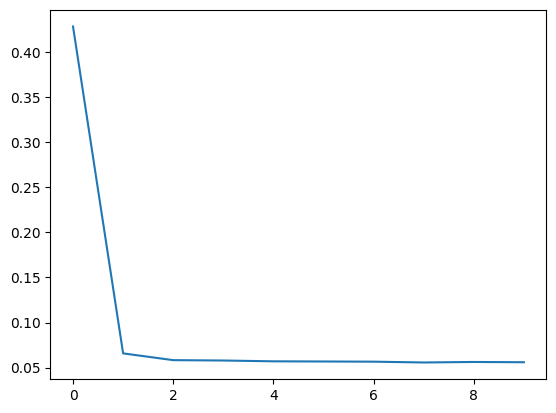

In [4]:
tau = 3
# we take a sliding window over the dataset and create samples of inputs to the model
x_train = torch.cat([y[i : i + tau][None, :] for i in range(N-tau)], dim=0)
y_train = torch.cat([y[i+tau][None] for i in range(N-tau)])

# create and fit model
model = LinearRegression(batch_size=16, epochs=10)
model.fit(x_train, y_train)

plt.plot(model.losses)

We can see that looking 1 step into the future leads to a good model

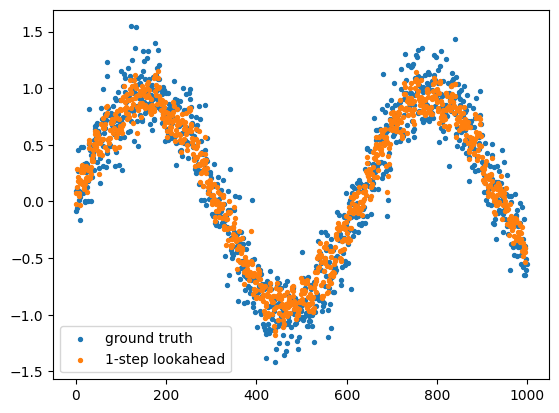

In [5]:
y_pred = model(x_train)
plt.scatter(x, y, s=8, label='ground truth')
plt.scatter(range(N-tau), y_pred.detach().numpy(), s=8, label='1-step lookahead')
plt.legend()

However, a big problem is that looking further into the future leads to accumulation of cumulative error, which causes very bad predictions.

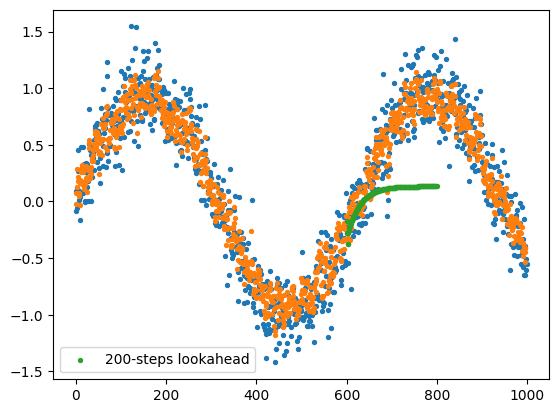

In [6]:
def look_k_steps_into_future(model, k, tau, x_instance):
    # concatenate predictions to make the next predictions
    for _ in range(k-tau):
        y_pred = model(x_instance[-tau:]).detach()
        x_instance = torch.cat([x_instance, y_pred])
    return x_instance

start = 600
steps = 200
future_preds = look_k_steps_into_future(model, steps, tau, x_train[start])

plt.scatter(x, y, s=8)
plt.scatter(range(N-tau), y_pred.detach().numpy(), s=8)
plt.scatter(range(start, start+steps), future_preds, s=8, label=f'{steps}-steps lookahead')
plt.legend()

## Basic RNN module

Maps input sequence to output sequence using update equations for each time step $t=1$ to $t = \tau$
\begin{align*}
    \textbf{a}^{(t)} &= \textbf{b} + \textbf{W}\textbf{h}^{(t-1)} + \textbf{U}\textbf{x}^{(t)}\\
    \textbf{h}^{(t)} &= \text{tanh}(\textbf{a}^{(t)})\\
    \hat{\textbf{y}}^{(t)} &= \text{softmax}(\textbf{c} + \textbf{V}\textbf{h}^{(t)})
\end{align*}
for 
- shared bias vectors $\textbf{b}, \textbf{c}$
- shared weight matrices:
  - $\textbf{W}$: hidden-to-hidden weights
  - $\textbf{U}$: input-to-hidden
  - $\textbf{V}$: hidden-to-output
- and input vectors $\textbf{x} \in \textbf{X}$

PyTorch handles the mathematics in an efficient way. In the following we define a custom torch module that contains the RNN as well as a linear layer followed by a softmax layer. This allows us to output a distribution of possible outputs for each sequence.   

In [15]:
class MyRNN(nn.Module):
    def __init__(self, 
                 num_inputs: int, 
                 num_hidden: int, 
                 num_outputs: int, 
                 n_layers: int,
                 dropout: float = 0.5) -> None:
        super().__init__()
        self.rnn = nn.RNN(num_inputs, num_hidden, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.out_layer = nn.LazyLinear(num_outputs)
    
    def forward(self, X: torch.Tensor, H: torch.Tensor = None):
        output, H = self.rnn(X, H)
        return self.out_layer(output), H

In [17]:
rnn = MyRNN(
    num_inputs=1,
    num_hidden=20,
    num_outputs=5,
    n_layers=3
)

batch_size, seq_len, n_inputs = 32, 50, 1
x = torch.randn(batch_size, seq_len, n_inputs)

y, h = rnn(x)

x.shape, y.shape, h.shape

(torch.Size([32, 50, 5]), torch.Size([3, 32, 20]))

## Sequence Dataset

Since we operate on sequences when using RNNs, we will be using a dataset where the data is ordered sequentially. 

Specifically, to showcase how to use RNNs, we will use a simple noisy sine wave as our time series. We denote the sequence length of the input sequence by $\tau$. 

- `src_X`: source input covariate sequence (simple enumeration for now $[\textbf{x}_0, \textbf{x}_1, \dots, \textbf{x}_T]$)
- `src_fX`: source input feature sequence (simple noisy sine wave $[\textbf{y}_0, \textbf{y}_1, \dots, \textbf{y}_T]$)
- `tgt_X`: source target covariate sequence (simple enumeration for now $[\textbf{x}_{T+1}, \textbf{x}_{T+2}, \dots, \textbf{x}_{T+\tau}]$)
- `tgt_fX`: source input feature sequence (simple noisy sine wave $[\textbf{y}_{T+1}, \textbf{y}_{T+2}, \dots, \textbf{y}_{T+\tau}]$)

Our learning problem becomes the following: given `src_fX`, we want to predict `tgt_fX`, or in other words:
$$
    [\hat{\textbf{y}}_T, \hat{\textbf{y}}_{T+1}, \dots, \hat{\textbf{y}}_{T+\tau}] = \text{RNN}(\textbf{y}_0, \textbf{y}_1, \dots, \textbf{y}_T)
$$

In [8]:
from torch.utils.data import Dataset


class BaseTimeSeriesDataset(Dataset):
    def __init__(
        self,
        X: torch.Tensor,
        fX: torch.Tensor,
        seq_len: int,
        shift: int
    ):
        """
        :param X: time steps (covariates)
        :param fX: features per time step
        :param seq_len: length of each sequence example in dataset
        :param shift: number of steps to shift the target values
        """
        self.seq_len = seq_len
        self.shift = shift
        self.X = X
        self.fX = fX
        self.mask = torch.tril(torch.ones((seq_len, seq_len)), diagonal=0)

    def __getitem__(self, index):

        sample = (
            self.X[index : index + self.seq_len],
            self.fX[index : index + self.seq_len],
            self.X[index + self.seq_len : index + self.seq_len + self.shift],
            self.fX[index + self.seq_len : index + self.seq_len + self.shift],
        )
        return sample

    def __len__(self):
        return len(self.X) - self.seq_len - self.shift

In [18]:
class SineSyntheticDataset(BaseTimeSeriesDataset):
    def __init__(
        self,
        len_timeseries: int,
        seq_len: int,
        shift: int,
        alpha: float = 0.1,
        noise: float = 0.1
    ):

        X = torch.arange(0, len_timeseries, dtype=torch.float32).reshape(-1, 1)
        fX = torch.sin(alpha * X) + torch.randn_like(X) * noise
        super().__init__(X, fX, seq_len, shift)

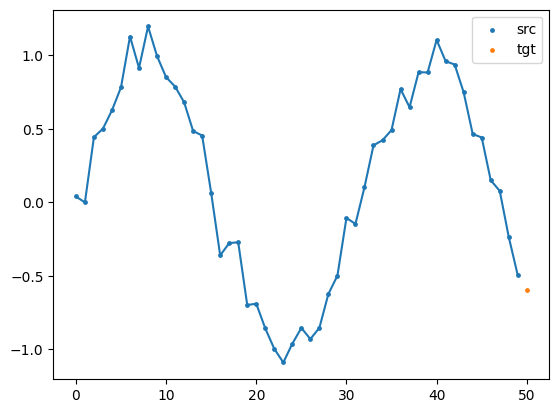

In [47]:
dataset = SineSyntheticDataset(
    len_timeseries=5000, 
    seq_len=50,
    shift=1,
    alpha=0.2, 
    noise=0.1
)

src_x, src_fx, tgt_x, tgt_fx = dataset[0]

plt.scatter(src_x, src_fx, s=6, label='src')
plt.plot(src_x, src_fx)
plt.scatter(tgt_x, tgt_fx, s=6, label='tgt')
plt.legend()

In [38]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

src_x, src_fx, tgt_x, tgt_fx = next(iter(dataloader))
src_x.shape, src_fx.shape, tgt_x.shape, tgt_fx.shape

(torch.Size([16, 50, 1]),
 torch.Size([16, 50, 1]),
 torch.Size([16, 1, 1]),
 torch.Size([16, 1, 1]))

## Define train and validation steps

In [41]:
def train_step(
        model: nn.Module, 
        dataloader: DataLoader, 
        optimizer: torch.optim, 
        device: torch.device,
        grad_clip_val: int = 5
    ):

    batch_loss = []
    for _, batch_X, _, batch_y in dataloader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        y_pred, _ = model(batch_X)
        loss = F.mse_loss(y_pred[:, -1:], batch_y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_val)
        optimizer.step()

        batch_loss.append(loss.detach().item())

    return np.sum(batch_loss) / len(batch_loss)

def valid_step(
        model: nn.Module, 
        dataloader: DataLoader, 
        device: torch.device,
    ):

    batch_loss = []
    with torch.no_grad():
        for _, batch_X, _, batch_y in dataloader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            y_pred, _ = model(batch_X)
            loss = F.mse_loss(y_pred[:, -1:], batch_y)

            batch_loss.append(loss.detach().item())

    return np.sum(batch_loss) / len(batch_loss)

## Setup + train loop

In [ ]:
# Training variables
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0002

/home/jan/programming/python-dev/ZM001-2425-artificial-intelligence/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch=0	train_loss=0.3803746777196084	valid_loss=0.2929031252861023
epoch=1	train_loss=0.16578298584828455	valid_loss=0.07292585199077924
epoch=2	train_loss=0.04524549204976328	valid_loss=0.027557958910862605
epoch=3	train_loss=0.02148935478180647	valid_loss=0.019555194365481535
epoch=4	train_loss=0.018905221379452174	valid_loss=0.018756729178130628
epoch=5	train_loss=0.017861354848249786	valid_loss=0.017972025585671268
epoch=6	train_loss=0.01702813482693126	valid_loss=0.01712929643690586
epoch=7	train_loss=0.016170956404699434	valid_loss=0.01610920907308658
epoch=8	train_loss=0.015362102155303281	valid_loss=0.015150635503232479
epoch=9	train_loss=0.014547819639706323	valid_loss=0.014462711786230405
epoch=10	train_loss=0.01349949514523389	valid_loss=0.01361523475497961
epoch=11	train_loss=0.012450987709716203	valid_loss=0.012658897352715333
epoch=12	train_loss=0.011974740946184724	valid_loss=0.012657879541317621
epoch=13	train_loss=0.011832297967386341	valid_loss=0.012498024106025695
e

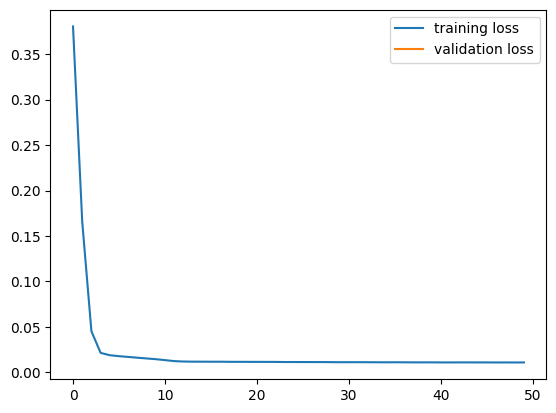

In [43]:
import torch.utils
from torch.utils.data import DataLoader

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

seq_len = 20
dataset = SineSyntheticDataset(
    len_timeseries=10000, 
    seq_len=50,
    shift=1,
    alpha=0.1, 
    noise=0.1
)

train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

n_hidden = 16
rnn = MyRNN(
    num_inputs=1, 
    num_hidden=n_hidden, 
    num_outputs=1, 
    n_layers=1,
    dropout=0.3
).to(DEVICE)

optim = torch.optim.AdamW(rnn.parameters(), LEARNING_RATE)

train_losses, valid_losses = [], []

for i in range(EPOCHS):
    
    train_loss = train_step(rnn, train_dataloader, optim, DEVICE)
    train_losses.append(train_loss)
    
    valid_loss = valid_step(rnn, valid_dataloader, DEVICE)
    valid_losses.append(valid_loss)

    print(f"epoch={i}\ttrain_loss={train_losses[-1]}\tvalid_loss={valid_losses[-1]}")

plt.plot(train_losses, label="training loss")
plt.plot(valid_loss, label="validation loss")
plt.legend()

In [14]:
idx = 6

src_x, src_fx, tgt_x, tgt_fx = test_set[idx]


In [ ]:
def predict(self, prefix_tgt_fX: list[int], horizon: int, shift: int):
    
    H, outputs = None, []

    with torch.no_grad():
        self.eval()
            
        for step in range(horizon):
            
            out, H = model(pred_X[:, -seq_len:], H)
            pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
            pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
            
            _, _, tgt_x, tgt_fx = dataset[idx+step]
            tgt_X.append(tgt_x[-1].squeeze().item())
            tgt_fX.append(tgt_fx[-1].squeeze().item())

    return outputs
    # plt.figure(figsize=(20, 5))
    # plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
    # plt.plot(tgt_X, tgt_fX, '--b', label="Target")
    # plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
    # plt.legend()